# Similarity measures

## Temporal: 2d Kolmogorov-Smirnov test on unaggregated point data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from itertools import pairwise

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from humanleague import SobolSequence
from more_itertools import consume
from ndtest import ks2d2s
from shapely import Point

from spatial import SpatialUnit, get_force_boundary, map_to_spatial_unit
from utils import (
    CATEGORIES,
    extract_crime_data,
    tokenize_force_name,
)

In [ ]:
FORCE = "West Yorkshire"
CATEGORY = CATEGORIES[1]  # ASB
OBSERVATION_WINDOW = 3  # months
AREA: SpatialUnit = "STREET"
AREA_PARAMETERS = defaultdict(
    dict,
    {
        "LSOA": {"resolution": "GC"},
        "GRID": {"size": 200.0},
        "HEX": {"size": 124.0},
        "H3": {"resolution": 8},
    },
)

In [6]:
force_boundary = get_force_boundary(FORCE)
raw_crime_data = extract_crime_data(FORCE)
# filter by catgegory and remove any points
raw_crime_data = raw_crime_data[raw_crime_data["Crime type"] == CATEGORY]
raw_crime_data = raw_crime_data[raw_crime_data.geometry.intersects(force_boundary.geometry.union_all())]
raw_crime_data

,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,geometry
Crime ID,,,,,,,,
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Queen'S Gardens,E01010692,Bradford 001D,Anti-social behaviour,POINT (411354.013 447133.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411854.969 447613.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Wells Road,E01010692,Bradford 001D,Anti-social behaviour,POINT (411758.03 447302.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411854.969 447613.948)
NaN,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Springs Lane,E01010691,Bradford 002A,Anti-social behaviour,POINT (412391.978 447481.039)
...,...,...,...,...,...,...,...,...
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near John Street,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446750.007 410878.044)
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Beech Street,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446414.024 410431.008)
NaN,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Princess Avenue,E01011863,Wakefield 044D,Anti-social behaviour,POINT (446666.975 410800.005)


2022-05 2022-06 0.2561426415725091
2022-06 2022-07 0.4659742139744317
2022-07 2022-08 0.0006029021528579711
2022-08 2022-09 0.0010153470625392101
2022-09 2022-10 8.459414024038247e-06
2022-10 2022-11 6.544199522617816e-05
2022-11 2022-12 0.003429216988485616
2022-12 2023-01 0.012794805544705473
2023-01 2023-02 0.07153961455875862
2023-02 2023-03 0.0018068090076377064
2023-03 2023-04 5.264448568822736e-06
2023-04 2023-05 0.0028045205427904446
2023-05 2023-06 0.011035070141691406
2023-06 2023-07 7.212892871053665e-06
2023-07 2023-08 0.0004232256450203931
2023-08 2023-09 0.19361805294986517
2023-09 2023-10 3.582699819915033e-05
2023-10 2023-11 0.20660197329686858
2023-11 2023-12 0.15625237144703186
2023-12 2024-01 0.05981410863322443
2024-01 2024-02 0.28456865248558716
2024-02 2024-03 0.005829837606174709
2024-03 2024-04 0.04921142530752049
2024-04 2024-05 3.387803096517559e-05
2024-05 2024-06 9.574280995826413e-05
2024-06 2024-07 0.015965477998002544
2024-07 2024-08 0.0017064944821418727

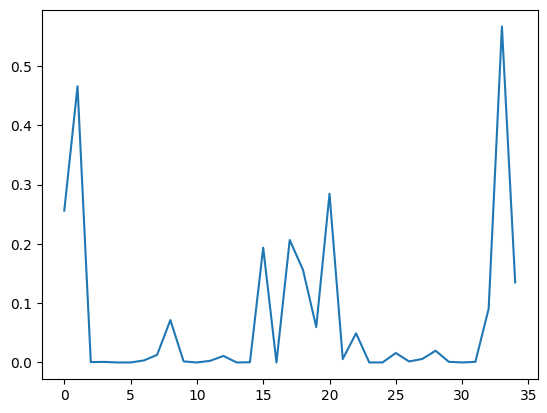

In [7]:
months = sorted(raw_crime_data.Month.unique())
sim_scores = []
for left, right in pairwise(months):
    points_left = raw_crime_data[raw_crime_data.Month == left].geometry
    points_right = raw_crime_data[raw_crime_data.Month == right].geometry

    sim_scores.append(
        ks2d2s(points_left.x.to_numpy(), points_left.y.to_numpy(), points_right.x.to_numpy(), points_right.y.to_numpy())
    )
    print(left, right, sim_scores[-1])

plt.plot(sim_scores)

# Spatial: Quasirandomly sampled MSE

- sample counts using 2 different spatial units and normalise (i.e. density - count/area)
- generate a set of quasirandom sampling points
- spatially join densities at these points and compute squared differences
- report the mean

Density is scaled to crimes per square kilometre

In [8]:
# Aggregate onto two different grids

crime_data1, spatial_units1 = map_to_spatial_unit(raw_crime_data, force_boundary, "GRID", size=500.0, offset=(250, 250))
crime_data1 = spatial_units1.join(crime_data1.groupby("spatial_unit").size().rename("count")).fillna(0)
crime_data1["density"] = crime_data1["count"] / crime_data1.area
# crime_data1.sort_values(by="density", ascending=False)

crime_data2, spatial_units2 = map_to_spatial_unit(raw_crime_data, force_boundary, "GRID", size=500.0)
crime_data2 = spatial_units2.join(crime_data2.groupby("spatial_unit").size().rename("count")).fillna(0)
crime_data2["density"] = crime_data2["count"] / crime_data2.area
# crime_data2.sort_values(by="density", ascending=False)

In [12]:
def generate_sample_points(sample_region: gpd.GeoDataFrame, n_points: int, *, skips: int = 0) -> gpd.GeoDataFrame:
    """Points returned my not exactly match number requested"""
    xmin, ymin, xmax, ymax = force_boundary.total_bounds

    offset = [xmin, ymin]
    scale = [xmax - xmin, ymax - ymin]

    # work out oversample to get ~N within sample region
    oversample = int(n_points / force_boundary.area * (scale[0] * scale[1]))

    gen = SobolSequence(2)
    consume(gen, skips)
    # or... random offset?

    sample_points = (
        gpd.GeoDataFrame(geometry=[Point(next(gen) * scale + offset) for _ in range(oversample)], crs="epsg:27700")
        .sjoin(force_boundary[["geometry"]])
        .drop(columns="index_right")
        .reset_index(drop=True)
    )
    return sample_points


def sample_rmse(sample_points: gpd.GeoDataFrame, crime_data1: gpd.GeoDataFrame, crime_data2: gpd.GeoDataFrame) -> float:
    """Crime data should have a 'density' column"""

    sampled = sample_points.sjoin(crime_data1[["geometry", "density"]]).rename(
        columns={"index_right": "index1", "density": "density1"}
    )
    sampled = sampled.sjoin(crime_data2[["geometry", "density"]]).rename(
        columns={"index_right": "index2", "density": "density2"}
    )

    return np.sqrt(((sampled.density1 - sampled.density2) ** 2).mean())


sample_points = generate_sample_points(force_boundary, 10000, skips=65536 * 4)
sample_points.explore()
# sample_rmse(sample_points, crime_data1, crime_data2)

/tmp/ipykernel_129937/584808099.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  oversample = int(n_points / force_boundary.area * (scale[0] * scale[1]))


In [13]:
areal_unit_scale = 1_000_000  # km2
size = 900
offsets = np.arange(0, size, size / 10)

crime_data1, spatial_units1 = map_to_spatial_unit(raw_crime_data, force_boundary, "H3", resolution=8)
crime_data1 = spatial_units1.join(crime_data1.groupby("spatial_unit").size().rename("count")).fillna(0)
crime_data1["density"] = crime_data1["count"] / crime_data1.area * areal_unit_scale

mses = []
for offset in offsets[1:]:
    crime_data2, spatial_units2 = map_to_spatial_unit(
        raw_crime_data, force_boundary, "H3", resolution=8, offset=(offset, 0)
    )
    crime_data2 = spatial_units2.join(crime_data2.groupby("spatial_unit").size().rename("count")).fillna(0)
    crime_data2["density"] = crime_data2["count"] / crime_data2.area * areal_unit_scale
    mses.append(sample_rmse(sample_points, crime_data1, crime_data2))

In [14]:
# overall crime density
mean_density = len(raw_crime_data) / force_boundary.area.sum() * 1_000_000
mean_density

np.float64(40.2610289523752)

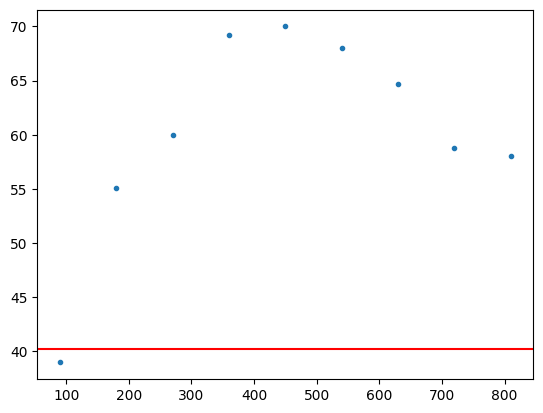

In [15]:
fix, ax = plt.subplots()
ax.plot(offsets[1:], mses, ".")
ax.axhline(mean_density, 0, size, c="r")